<a href="https://colab.research.google.com/github/jahnavi-maddhuri/JahnaviMaddhuri-DukeXAI/blob/main/InterpretableML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIPI 590 - XAI | Assignment 2**
Interpretable ML. This assignment is about comparing Linear Regression, Logistic Regression and GAM models. I focus on understanding how these models differ in their key assumptions and how they vary in performance and interpretability. It is based on the kaggle dataset for Churn for a Telecom company.


**Jahnavi Maddhuri**

Clickable Link: https://colab.research.google.com/github/jahnavi-maddhuri/JahnaviMaddhuri-DukeXAI/blob/main/InterpretableML.ipynb

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jahnavi-maddhuri/JahnaviMaddhuri-DukeXAI/blob/main/InterpretableML.ipynb)

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy.stats as stats

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, confusion_matrix

from pygam import LogisticGAM, s, f
from pygam import LinearGAM, GammaGAM, s

### **Load Data**
Load the data and get a an overview of the columns, the size of the a data and a glimpse of the dataset.

In [2]:
path = 'https://raw.githubusercontent.com/jahnavi-maddhuri/JahnaviMaddhuri-InterpretableML/refs/heads/main/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(path)

## **Task 1: EDA to Check Assumptions**
Perform an exploratory analysis of the dataset to understand the relationships between different features and the target variable (churn). Use appropriate visualizations and statistical methods to determine whether assumptions about linear, logistic, and GAM models are met.
<br>

### **EDA**
I first produce some Exploratory visualizations and statistics for my own personal understanding of the dataset.

In [3]:
print('Columns in Dataset:\n', df.columns)
print()
print('Dataset Shape:\n', df.shape)

# See example values of each column
df[['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup']].head()

Columns in Dataset:
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Dataset Shape:
 (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No


In [4]:
# Sample values of each column (cont.)
df[['OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']].head()

,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Convert columns to numeric
df['TotalCharges'] = df['TotalCharges'].astype(str).replace(r'^\s*$', np.nan, regex=True).astype(float)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# Summary stats on numeric cols
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
# Churn distribution
df.groupby('Churn').count()[['customerID']].reset_index().rename(columns={'customerID': 'Count'})

,Churn,Count
0,No,5174
1,Yes,1869


There are many more customers who did not churn than that did. This is 2-3x the proportion.

### **Linear Regression Assumptions**
Below, I check Linear Regression Assumptions. I've reproduced the assumptions according to lecture slides and indicated whether each assumption was satisfied with a ✅ (Satisified) or ❌ (Violated)

1. ❌ **Linearity** Relationship between X and Y should be linear
2. ✅ **Independence** Observations should be independent of one another
3. ❌ **Homoscedasticity** Constant variance of residuals accross all X
4. ❌ **Normality** Residuals should be normally distributed
5. ❌ **No multicollinearity** No perfect linear relationships across predictors
6. ❌ **No autocorrelation** Residuals should not be correlated over time
7. ✅ **No endogeneity** No missing predictors or two-way causality
8. ❌ **Correct specification** Correct variables in correct functional forms are modeled.

In [7]:
# convert churn to numerical
if df['Churn'].dtype != 'float64':
  df['Churn'] = df['Churn'].map({'Yes':1, 'No':0}).astype(float)

# predictors shouldn't include id/churn
X_col_names = [c for c in df.columns if c not in ['customerID', 'Churn']]

# categ/numer variables for formula
categorical = df[X_col_names].select_dtypes(
    include=['object', 'category', 'bool']).columns.tolist()
numerical = [c for c in X_col_names if c not in categorical]

# fit ols
formula = f"Churn ~ " + " + ".join([f"C({c})" for c in categorical] + numerical)
fit_df = df[['Churn'] + X_col_names].dropna()
linear_results = smf.ols(formula, data=fit_df).fit()

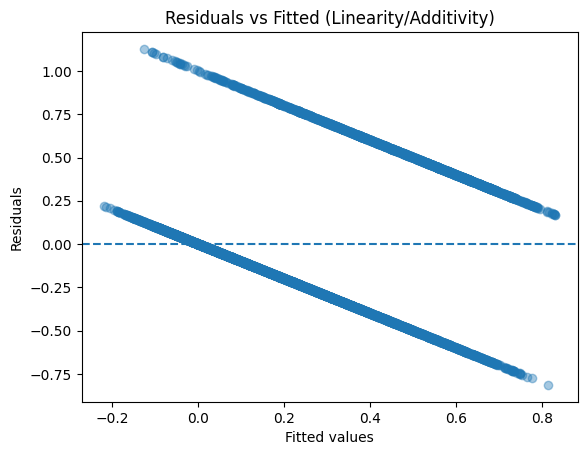

In [8]:
# Assumption 1 and 3: Linearity and Homescedasticity
plt.figure()
plt.scatter(linear_results.fittedvalues, linear_results.resid, alpha=0.4)
plt.axhline(0, ls='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Linearity/Additivity)")
plt.show()

Assumptions 1 and 3 both fail due to the clear pattern in the graph above. There are two distinct lines in the chart (most probably referencing the two distinct target classes, since the target variable is not continuous). The clear line shape fails the linearity assumptions and the clear pattern fails homescedasticity.

I check assumption 2 using the Kaggle dataset descriptor which asserts that these each record is independent. To check the first assumption, I fit an OLS model below to check some of the assumptions.

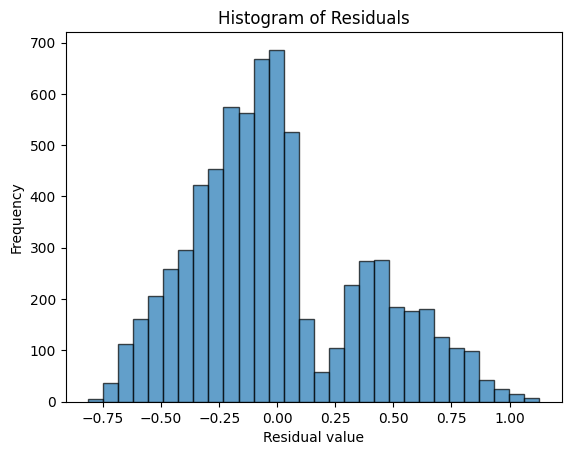

In [9]:
# Assumption 4: Normality
plt.hist(linear_results.resid, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

Assumption 4 fails beacuse the residuals are not normally distributed. There are two distinct peaks in this graph (expected as there are two distinct outcomes for the binary response variable). A normal distribution should have one clear peak.

In [22]:
# Assumption 5: No multicollinearity
np.seterr(divide='ignore', invalid='ignore')
# take predictors, make dummies for cat, drop na
X = df[X_col_names]
X = pd.get_dummies(X, drop_first=True)
X = add_constant(X)
X = X.astype(float)
X = X.dropna()

# Compute VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                                 Variable         VIF
0                                   const    0.000000
1                           SeniorCitizen    1.153220
2                                  tenure    7.584453
3                          MonthlyCharges  866.089640
4                            TotalCharges   10.811490
5                             gender_Male    1.002106
6                             Partner_Yes    1.462988
7                          Dependents_Yes    1.381598
8                        PhoneService_Yes         inf
9          MultipleLines_No phone service         inf
10                      MultipleLines_Yes    7.289761
11            InternetService_Fiber optic  148.500814
12                     InternetService_No         inf
13     OnlineSecurity_No internet service         inf
14                     OnlineSecurity_Yes    6.338349
15       OnlineBackup_No internet service         inf
16                       OnlineBackup_Yes    6.796678
17   DeviceProtection_No int

This assumption check failed. According to the above VIF scores, there are many that are much larger than 10 and some that even have a score of "infinity." These means that the multicollinearity assumption has been violated and many of these variables are highly correlated.

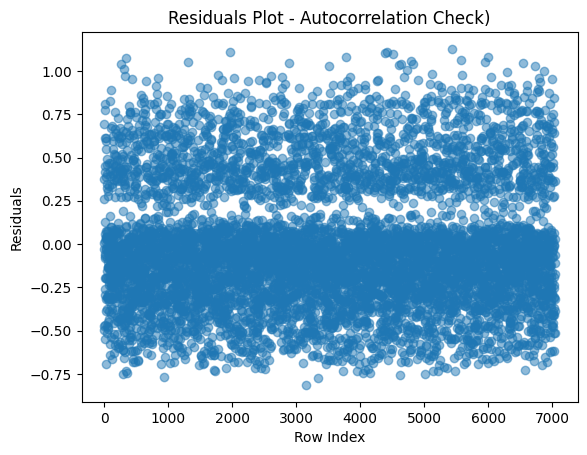

In [11]:
# Assumption 6: No autocorrelation
plt.plot(linear_results.resid, marker='o', linestyle='', alpha=0.5)
plt.xlabel("Row Index")
plt.ylabel("Residuals")
plt.title("Residuals Plot - Autocorrelation Check)")
plt.show()


There is a band above 0 where we see a pattern without many points. This fails the independence of errors assumption and is a result of fitting to binary data. Ideally, we should see an even distribution of points, without any pattern such as the band we observe above.

The last two assumptions depend more on the specific composition of features and regression methodology used.

No endogeneity refers to ensuring that predictor variables are not correlated to error term. Generally, this means that there aren't any missing confounding variables and there is no two way causality between the predictor and the outcome. From my current domain knowledge around the problem, I don't see a clear violation of this assumption.

Correct specification assumption is violated here as the current model includes factors that are multicollinear and the response variable is not continuous.

### **Logistic Regression Assumptions**
According to Lecture slides, I've reproduced the logistic regression assumptions below, indicated whether or not we've satisfied these assumptions followed by justification.
1. ❌ **Linearity**
2. ❌ **No multicollinearity**
3. ✅ **Independence of observations**
4. ❌ **No influential outliers**
5. ✅ **Absence of perfect separation**
6. ✅ **Large sample size**

In [12]:
# Assumption 1: Linearity
cont = ['tenure', 'MonthlyCharges', 'TotalCharges']

# add interaction: X * log(X)
for col in cont:
    df[f'{col}_log'] = df[col].apply(lambda x: x if x > 0 else np.nan)
    df[f'{col}_log'] = df[col] * np.log(df[f'{col}_log'])

# formula = X*log(X)
formula = 'Churn ~ ' + ' + '.join(cont + [f'C({c})' for c in categorical])
formula += ' + ' + ' + '.join([f'{c}_log' for c in cont])

# log model
logit_model = smf.logit(formula=formula, data=df.dropna()).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.408983
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7006
Method:                           MLE   Df Model:                           25
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2937
Time:                        00:15:54   Log-Likelihood:                -2876.0
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

To get to the result above, I started by asking ways ChatGPT5 about ways to check this assumption for a logit relationship. I then prompted chatgpt5 to tell me more about the Box Tidwell test and give me an example. I learned that this test defines the predictor/response relationship as Y ~ X*log(X), checking that no predictors are statisticall significant. Using that sample code, I plugged in my data to arrive at the code above. Based on what I learned, if the coefficients in this model are not statistically significant (p>0.05), then there is no evidence of violation of this assumption. In this case, there are many variables with very small p values. The effect of these predictors on the log-odds is not purely linear. This assumption is violated.

Assumption 2 regarding multicollinearity is also violated. This was shown above while checking the Linear Regression assumptions.

Assumption 3 regarding independence of observations holds as shown above while checking the Linear Regression assumptions.

Optimization terminated successfully.
         Current function value: 0.427567
         Iterations 8


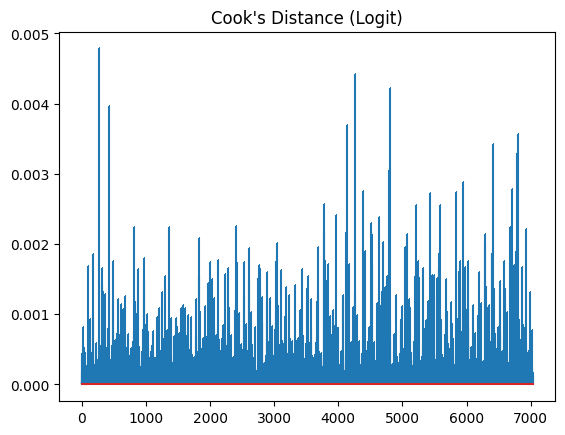

In [13]:
# Assumption 4: No influential outliers
X = df.dropna()[X_col_names]
X = pd.get_dummies(X, drop_first=True)
X = add_constant(X)
X = X.astype(float)
X = X.drop(columns=[ # drop columns with high multicollinearity
    'MonthlyCharges', 'PhoneService_Yes', 'MultipleLines_No phone service',
    'InternetService_Fiber optic', 'InternetService_No',
    'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
    'DeviceProtection_No internet service', 'TechSupport_No internet service',
    'StreamingTV_No internet service', 'StreamingTV_Yes',
    'StreamingMovies_No internet service', 'StreamingMovies_Yes'
    ])
y = df.dropna()['Churn']
logit_model = sm.Logit(y, X).fit()
influence = logit_model.get_influence()
summary_frame = influence.summary_frame()

summary_frame["cooks_d"] = influence.cooks_distance[0]
plt.stem(summary_frame["cooks_d"], markerfmt=",")
plt.title("Cook's Distance (Logit)")
plt.show()

Assumption 4 is not satisfied since the number of outliers are so large. The data is very noisy and many points go beyond the red line plotted. Since there is no single or few points that are extreme, I keep all the points in future model building.

In [14]:
# Assumption 5: Absence of perfect separation
for r in categorical:
  print(r, df[[r, 'Churn']].drop_duplicates().sort_values('Churn'))
  print()

gender    gender  Churn
0  Female    0.0
1    Male    0.0
2    Male    1.0
4  Female    1.0

Partner   Partner  Churn
0     Yes    0.0
1      No    0.0
2      No    1.0
8     Yes    1.0

Dependents    Dependents  Churn
0          No    0.0
6         Yes    0.0
2          No    1.0
18        Yes    1.0

PhoneService    PhoneService  Churn
0            No    0.0
1           Yes    0.0
2           Yes    1.0
20           No    1.0

MultipleLines        MultipleLines  Churn
0   No phone service    0.0
1                 No    0.0
6                Yes    0.0
2                 No    1.0
5                Yes    1.0
20  No phone service    1.0

InternetService    InternetService  Churn
0              DSL    0.0
6      Fiber optic    0.0
11              No    0.0
2              DSL    1.0
4      Fiber optic    1.0
22              No    1.0

OnlineSecurity          OnlineSecurity  Churn
0                    No    0.0
1                   Yes    0.0
11  No internet service    0.0
2                 

This assumption has passed because amongst all the predictors, there isn't one class that completely coincides with the output, Churn. Every predictor category is represented by both Churn responses.

Assumption 6 also is satisfied above in EDA when we see each class has over 1500 observations.

For GAMs, the assumptions are more relaxed, especially because it doesn't assume linearity (which failed for both linear and logistic regression). Still it assumes independence, using the correct link/distribution, smoothness of effects, and no extreme multicollinearity.

## **Task 2: Linear Regression**
Treat the churn variable as a continuous variable (e.g., 0 for staying, 1 for churning) and build a linear regression model to predict churn. Interpret the coefficients and assess the model's performance.

In [15]:
# Load X,y
X = df.dropna()[X_col_names]
X = pd.get_dummies(X, drop_first=True)
X = add_constant(X)
X = X.astype(float)
X = X.drop(columns=[ # drop columns with high multicollinearity
    'MonthlyCharges', 'PhoneService_Yes', 'MultipleLines_No phone service',
    'InternetService_Fiber optic', 'InternetService_No',
    'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
    'DeviceProtection_No internet service', 'TechSupport_No internet service',
    'StreamingTV_No internet service', 'StreamingTV_Yes',
    'StreamingMovies_No internet service', 'StreamingMovies_Yes'
    ])
y = df.dropna()['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred

# Fit linear regression
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")



Linear Regression:
MSE: 0.15
R2 Score: 0.22
const: 0.0000
SeniorCitizen: 0.0295
tenure: -0.1487
TotalCharges: 0.0584
gender_Male: -0.0021
Partner_Yes: 0.0044
Dependents_Yes: -0.0168
MultipleLines_Yes: 0.0294
OnlineSecurity_Yes: -0.0270
OnlineBackup_Yes: -0.0030
DeviceProtection_Yes: 0.0141
TechSupport_Yes: -0.0243
Contract_One year: -0.0657
Contract_Two year: -0.0579
PaperlessBilling_Yes: 0.0354
PaymentMethod_Credit card (automatic): -0.0056
PaymentMethod_Electronic check: 0.0477
PaymentMethod_Mailed check: -0.0229


Coefficient Interpretation:
- **SeniorCitizen**	Senior citizens have a 0.0295 higher predicted probability of churn.
- **tenure** For every additional month the customer has stayed with the company, there is a 0.14 lower predicted probability of churn.
- **TotalCharges**	For every 1$ increase in total charges, there is a .05 higher probability of churn.
- **gender_Male** Male customers have a 0.002 lower predicted probability of churn.
- **Partner_Yes** Customers with a partner have 0.0044 higher predicted probability of churn.
- **Dependents_Yes** When a customer has dependents, they have a 0.0168 lower probability of churn
- **MultipleLines_Yes** When customers have multiple lines over having a phone service, but not having multiple lines, there is a 0.0294 higher predicted probability of churn.
- **OnlineSecurity_Yes** When customers have online security, they have a 0.0270 lower predicted probability to churn.
- **OnlineBackup_Yes** When customers have an online backup, they have 0.003 lower predicted probability to churn.
- **DeviceProtection_Yes** When customers have device protection, they have a 0.0141 higher predicted probability to churn.
- **TechSupport_Yes** When customers have Tech Support, they have a 0.0243 lower predicted probability to churn.
- **Contract_One year** When a customer has a one year contract over a month-to-month contract, they have a 0.0657 lower predicted probability of churn.
- **Contract_Two year**	When a customer has a one year contract over a month-to-month contract, they have a 0.0579 lower probability of churn.
- **PaperlessBilling_Yes** When a customer uses paperless billing, they have a 0.0354 higher predicted probability to churn.
- **PaymentMethod_Credit card (automatic)** When a customer uses an electronic check for their payment method as opposed to an automatic bank transfer, there is a 0.0056 lower predicted probability of churn.
- **PaymentMethod_Electronic check** When a customer uses an electronic check for their payment method as opposed to an automatic bank transfer, there is a 0.0477 higher predicted probability of churn.
- **PaymentMethod_Mailed check** When a customer uses a mailed check for their payment method as opposed to an automatic bank transfer, there is a 0.0229 lower predicted probability of churn.

This is not a very strong model. The R-squared value is 0.22, meaning that only 22% of the variance in Churn is explained by the predictors in our model. Further, the mean squared error between the predicted and actual target values in our test sample was 0.15.

## **Task 3: Logistic Regression**
Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.

In [17]:
def evaluate_logistic_model(X_train, X_test, y_train, y_test, model_name):
    # fit log model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # model performance
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n{model_name}:")
    print(f"Accuracy: {acc:.3f}")
    print(f"AUC: {auc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    log_reg_summary = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': [round(coef, 4) for coef in model.coef_[0]],
        'Odds Ratio': [round(coef,3) for coef in np.exp(model.coef_[0])]
    })
    return log_reg_summary
evaluate_logistic_model(X_train, X_test, y_train, y_test, "Logistic Regression")


Logistic Regression:
Accuracy: 0.786
AUC: 0.825
Confusion Matrix:
 [[928 105]
 [196 178]]


,Feature,Coefficient,Odds Ratio
0,const,-0.0754,0.927
1,SeniorCitizen,0.3698,1.447
2,tenure,-0.0841,0.919
3,TotalCharges,0.0007,1.001
4,gender_Male,-0.0366,0.964
5,Partner_Yes,0.0682,1.071
6,Dependents_Yes,-0.2684,0.765
7,MultipleLines_Yes,0.2707,1.311
8,OnlineSecurity_Yes,-0.4280,0.652
9,OnlineBackup_Yes,-0.0675,0.935


### **Model Performance**
Accuracy = 0.786 - The model correctly classifies about 79% of cases.

AUC = 0.825 - The model is able to classify the churn much better than random guessing. This is a fairly strong model.

Confusion Matrix:
||Predicted No Churn|Predicted Churn|
|-|-|-|
|**Actual No Churn**| 928| 105|
|**Actual Churn**| 196| 178|

**Recall** $=\frac{178}{178+196}=0.476=47.6$%

Amongst all of the actual churners, the model only correctly predicts a little under half. This means the model misses many churners (196 false negatives).

**Precision** $=\frac{178}{178+105}=0.629=62.9$%

When the model predicts a customer will churn, it is only able to accurately do so about 63% of the time. This means there aren't as many false positives (105 false positives)

<br>
Interpretation of coefficients is below and represents the effect when all other factors are held constant:

- **SeniorCitizen**

  $e^{0.3698}=0.447$ Senior citizens have 45% higher odds of churn.
- **tenure**

  $e^{-0.0841}=-0.919$ For every additional year the customer spends with the company, there is 8% lower odds of churn.
- **TotalCharges**

  $e^{0.0007}= 1.001$ For every additional 100 dollars in total charges, there is 10% higher odds of churn.
- **gender_Male**

  $e^{-0.0366}=0.964$ Males have 4% lower odds of churn.
- **Partner_Yes**

  $e^{0.0682}=1.071$ Customers with partners have 7% higher odds of churn.
- **Dependents_Yes**

  $e^{-0.2684}=0.765$ When customers have dependents they have a 23% lower odds of churn.
- **MultipleLines_Yes**

  $e^{0.2707}=1.311$ When customers have multiple lines, there is 31% higher odds of churn.
- **OnlineSecurity_Yes**

  $e^{-0.4280}=0.652$ When a customer has online security, there is 35% lower odds of churn.
- **OnlineBackup_Yes**

  $e^{-0.0675}=0.935$ Customers with an online backup have 6% lower odds of churn.
- **DeviceProtection_Yes**

  $e^{0.1321}=1.141$ Customers with device protection have 14% higher odds of churn.
- **TechSupport_Yes**

  $e^{-0.3875}=0.679$ When a customer has tech support there is 32% lower odds of churn.
- **Contract_One year**

  $e^{-0.9185}=0.399$ When a customer has a one year contract as opposed to a month-to-month contract, there is 60% lower odds of churn.
- **Contract_Two year**

  $e^{-1.6171}=0.198$ When a customer has a two year contract as opposed to a month-to-month contract, there is 80% lower odds of churn.
- **PaperlessBilling_Yes**

  $e^{0.4704}=1.601$ When a customer uses paperless billing, they have a 60% higher odds of churn.
- **PaymentMethod_Credit card (automatic)**

  $e^{-0.1393}=0.870$ When a customer uses an automatic credit card payment method as opposed to autmatic bank transfers, there is 13% lower odds of churn.
- **PaymentMethod_Electronic check**

  $e^{0.4009}=1.493$ When a customer uses an electronic check as opposed to an automatic bank transfer, there is 49% higher odds of churn.
- **PaymentMethod_Mailed check**

  $e^{-0.3482}=0.706$ When a customer uses a mailed check as opposed to an automatic bank transfer, there is 29% lower odds of churn.


## **Task 4: Generalized Additive Model (GAM)**
Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model.

In [18]:
X_train_gam = X_train.drop(columns=['const'])
X_test_gam = X_test.drop(columns=['const'])

X_train_np = X_train_gam.to_numpy()
X_test_np = X_test_gam.to_numpy()

y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

cont = [list(X_train_gam.columns).index(col_name) for col_name in [
    'tenure', 'TotalCharges']]

cat = [list(X_train_gam.columns).index(col_name) for col_name in [
    'SeniorCitizen', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
    'MultipleLines_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
    'DeviceProtection_Yes', 'TechSupport_Yes', 'Contract_One year',
    'Contract_Two year', 'PaperlessBilling_Yes',
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']]

In [19]:
def evaluate_gam(X_train, X_test, y_train, y_test, cont, cat, model_name):
  # s for continuous and f for categorical features
  terms = []
  for i in cont:
    terms.append(s(i))
  for i in cat:
    terms.append(f(i))
  term_sum = terms[0] + terms[1]
  for i in range(2, len(terms)):
    term_sum += terms[i]
  # fit model
  # terms = s(1) + s(2)
  gam = LogisticGAM(term_sum).gridsearch(X_train, y_train)

  # predict
  y_prob = gam.predict_proba(X_test)
  y_pred = (y_prob >= 0.5).astype(int)

  # model performace
  acc = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_prob)
  cm  = confusion_matrix(y_test, y_pred)

  print(f"\n{model_name}:")
  print(f"Accuracy: {acc:.3f}")
  print(f"AUC: {auc:.3f}")
  print("Confusion Matrix:\n", cm)

  print("\nGAM summary:")
  print(gam.summary())

  return gam #, y_pred, y_prob

gam_model = evaluate_gam(X_train_np, X_test_np, y_train_np, y_test_np,

                         cont=cont, cat=cat, model_name='GAM')

100% (11 of 11) |########################| Elapsed Time: 0:00:08 Time:  0:00:08



GAM:
Accuracy: 0.790
AUC: 0.831
Confusion Matrix:
 [[922 111]
 [185 189]]

GAM summary:
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     50.8805
Link Function:                        LogitLink Log Likelihood:                                  -2282.611
Number of Samples:                         5625 AIC:                                             4666.9828
                                                AICc:                                            4667.9676
                                                UBRE:                                               2.8369
                                                Scale:                                                 1.0
                                                Pseudo 

/tmp/ipython-input-2340777191.py:30: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


### **Model Performance**
Accuracy = 0.790 - The model correctly classifies about 79% of cases.

AUC = 0.831 - The model is able to classify the churn much better than random guessing. This is a fairly strong model.

Confusion Matrix:
||Predicted No Churn|Predicted Churn|
|-|-|-|
|**Actual No Churn**| 922| 111|
|**Actual Churn**| 185| 189|

**Recall** $=\frac{189}{189+185}=0.505=50.5$%

Amongst all of the actual churners, the model correctly predicts about half. This means the model misses many churners (185 false negatives).

**Precision** $=\frac{189}{189+111}=0.63=63$%

When the model predicts a customer will churn, it is only able to accurately do so about 63% of the time. This means there aren't as many false positives (111 false positives).

The predictors that were the most influential and statistically significant are those that correspond to s(1), s(2), f(0), f(7) and f(10-13). These correspond to **tenure**, the time the customer stayed with the company, **total charges**, the total charges of the customer over time, whether or not a customer was a **senior citizen**, whether or not a customer had **online security**,  whether a citizen had **tech support** or not, whether a citizen's contract was **one or two years** and whether a customer had **paperless billing** or not.

## **Task 5: Model Comparison**
Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.

### **Linear Regression**
**Interpretability**
This model is the easiest to interpret as the coefficients can simply be thought of as an effect towards the probability of churning.

**Performance** Although this model was highly interpretable, model fit was very poor. With an R squared value less than 0.3, less than 30% of the variability in churn was explained by the predictors in this model.

### **Logistic Regression**
**Interpretability** This model is slightly more difficult to interpret in comparison to linear regression because the coefficents are in a log-odds scale. However, once these coefficients are exponentiated and provided as odds ratio, they become much more interpretable.

**Performance** This model performed much better than linear regression. The accuracy on the test set was 78% with an AUC of 0.83. Even the precision and recall metrics were fairly high at 63% and 48%. This model performs far better than a classification model that would guess at random.

### **GAM**
**Interpretability** The GAM still is interpretable, but has another layer of complexity when compared to logistic regression. These models are more flexible, allowing smooth curves to model some of the continuous variables. If comprehended well, this model through dependence plots actually provides additional visibility into how specific factors impact probability to churn.

**Performance** The performace of this GAM is slightly better than the logistic regression model. This appears to be especially true when capturing nonlinear relationships between some of the categorical variables and response. The AUC and accuracy scores in this model were only slightly better than logistic regression.

### **Recommendation to Telecom Company**
I recommend that the Telecom Company start with the Logistic Regression model and first get stakeholder buy-in for this solution to prevent churn in the future. Since this model is strong and also easy to understand, stakeholder buy-in should be easier to garner. Then, as the project starts and models are being created, consider the GAM models too. Even if not every non-technical stakeholder understands this method, there could still be some interesting learnings that the developers can still use. Especially use GAM is prediction is prioritized over interpretability and Logistic Regression if the vice versa is true.